# Test pipeline
1. Create dataset: sequence of preporcessed examples ready to feed to neuralnet 
2. Create dataloader: define how dataset is loaded to neuralnet (batch size, order, computation optimizing ...)
3. Create model : a bunch of matrixes math to transform input tensor to output tensor
4. Training loop:
    + Forward 
    + Calculate loss
    + Backward
    + Monitoring: 
        + Evaluate metrics
        + Logger, back and forth
        + Visualize

# Import necessary packages

In [1]:

import os
import glob
import sys
import random

import matplotlib.pylab as plt
from PIL import Image, ImageDraw

import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

import numpy as np

from sklearn.model_selection import ShuffleSplit




torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

%matplotlib inline


sys.path.insert(0, '..')
from src.models.util import pipeline, Cornell_Grasp_dataset


# Create a transformer

In [2]:

def resize_img_label(image,label,target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    label = label.view(-1,2)
    # resize image and label
    image_new = TF.resize(image,target_size)
    for i in range(len(label)):
        x, y = label[i]
        label[i][0] = x/w_orig*w_target
        label[i][1] = y/h_orig*h_target     
    label = label.view(-1,8)
    return image_new,label

def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"]) 
    if params["sample_output"]:
        # randoom choose a grasp to be the ground truth      
        index = random.randint(0, len(label) -1)
        label = label[index]  
    image=TF.to_tensor(image)
    return image, label



# Create Data loader

In [3]:
def collate_fn(batch):
    imgs, labels = list(zip(*batch))
    targets = []
    for i in range(len(labels)):
        label = labels[i]
        target = torch.zeros(label.shape[0], label.shape[1] + 1)
        target[:,0] = i
        target[:, 1:] = label
        targets.append(target)

    targets = torch.cat(targets, 0)
    imgs = torch.stack([img for img in imgs])
    return imgs, targets, 

trans_params_train={
    "target_size" : (256, 256),
    "sample_output" : True
}


trans_params_val={
    "target_size" : (256, 256), 
    "sample_output" : False
}

path2data = "../data/processed/grasp.csv"



In [4]:
# create data set
train_ds = Cornell_Grasp_dataset(path2data,transformer,trans_params_train)
val_ds = Cornell_Grasp_dataset(path2data,transformer,trans_params_val)

sss = ShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
indices=range(len(train_ds))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index)) 

619
----------
266


In [5]:
from torch.utils.data import Subset

train_ds = Subset(train_ds,train_index)
print(len(train_ds))

val_ds = Subset(val_ds,val_index)
print(len(val_ds))

619
266


In [6]:
import matplotlib.pyplot as plt
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label = label.view(-1,2)
        for point in label:
            x,y= point
            plt.plot(x,y,'b+',markersize=10)

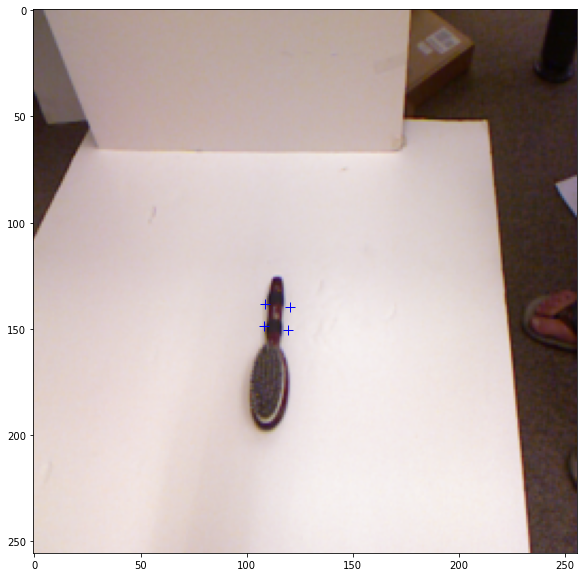

In [7]:

plt.figure(figsize=(10,10))
for img,label in train_ds:
    show(img,label)
    break

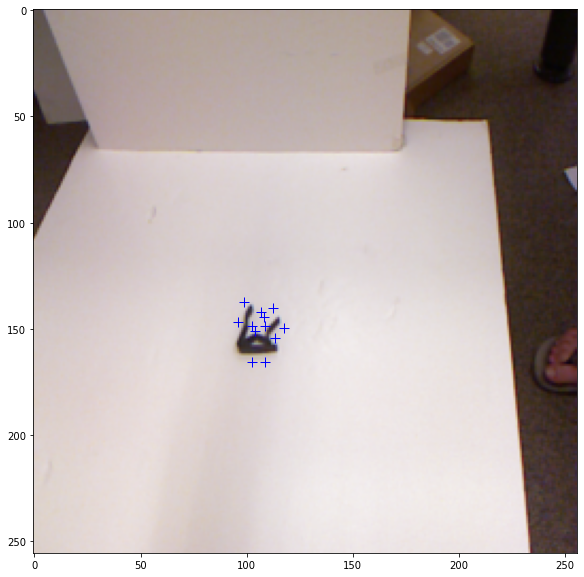

In [8]:
plt.figure(figsize=(10,10))
for img,label in val_ds:
    show(img,label)
    break

In [9]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [10]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([16, 3, 256, 256]) torch.float32
torch.Size([16, 8])


In [11]:
for img, label in val_dl:
    print(label.shape)
    break

torch.Size([160, 9])



# Create Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F


In [13]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [14]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)

In [15]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x


In [16]:
Net.__init__= __init__
Net.forward = forward

params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16, 
        "num_outputs": 5,
            }

model = Net(params_model)
device = torch.device("cuda")
model=model.to(device)

# Create optimizer

In [17]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)



# Training

In [18]:
path2models= "../models/"
mse_loss = nn.MSELoss(reduction="sum")

params_loss={
    "mse_loss": mse_loss,
    "gama": 5.0,
}

params_train={
    "num_epochs": 10,
    "optimizer": opt,
    "params_loss": params_loss,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}



In [19]:
pline = pipeline(model, params_train, device)
model,loss_hist, metric_history = pline.train_val()

Epoch 0/9, current lr=0.001
Copied best model weights!
train loss: 917.448405, accuracy: 0.00
val loss: 4311.949707, accuracy: 0.00
----------
Epoch 1/9, current lr=0.001
Copied best model weights!
train loss: 951.877019, accuracy: 0.00
val loss: 4258.750488, accuracy: 0.00
----------
Epoch 2/9, current lr=0.001
Copied best model weights!
train loss: 916.380351, accuracy: 0.00
val loss: 4147.939941, accuracy: 0.00
----------
Epoch 3/9, current lr=0.001
Copied best model weights!
train loss: 927.443255, accuracy: 0.00
val loss: 3942.686279, accuracy: 0.00
----------
Epoch 4/9, current lr=0.001
Copied best model weights!
train loss: 905.259289, accuracy: 0.00
val loss: 3597.537354, accuracy: 0.00
----------
Epoch 5/9, current lr=0.001
Copied best model weights!
train loss: 776.267316, accuracy: 0.00
val loss: 3053.513672, accuracy: 0.00
----------
Epoch 6/9, current lr=0.001
Copied best model weights!
train loss: 698.197698, accuracy: 0.00
val loss: 2271.682861, accuracy: 0.00
----------

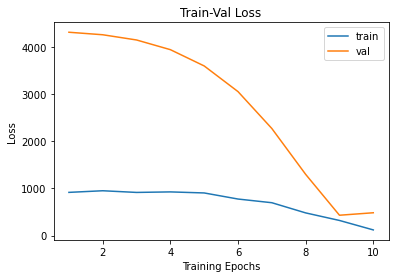

In [20]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

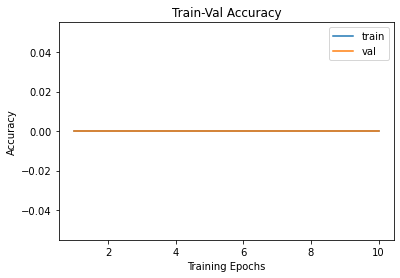

In [21]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_history["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_history["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()